# Amazon reviews - NLP Project
## with Text Processing, NER, Topic Modeling, Sentiment Analysis and WordClouds
This dataset contains 34,686,770 Amazon reviews from 6,643,669 users on 2,441,053 products, from the Stanford Network Analysis Project (SNAP). This subset contains 1,800,000 training samples and 200,000 testing samples in each polarity sentiment.

To achieve results faster we took a sample of 40000 reviews of the training set, in accordance to the Central Limit Theorem.<br>
We process the texts, like removing numbers, enter lines and stopwords and using methods like NER and Topic Modeling and its visualization with WordClouds. We use different Classifiers for Text Classificaton and TextBlob for Sentiment Analysis.

For more information about the dataset use the following Kaggle link:<br>
https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews

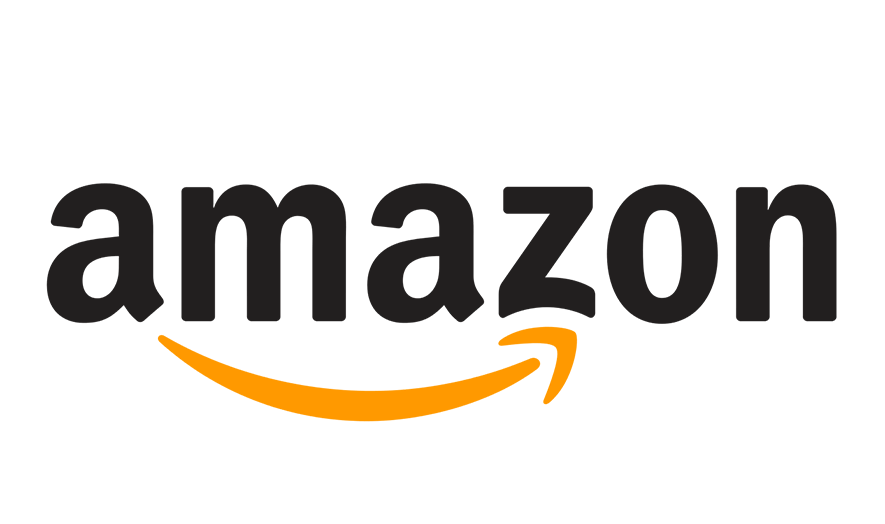

## Import Libraries and Load Data

In [1]:
#pip install svgling - was needed to show the entities (NER)

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image

import nltk
from nltk.corpus import stopwords
from nltk import pos_tag, ne_chunk # for NER
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amazon-reviews/amazon_review_polarity_csv.tgz
/kaggle/input/amazon-reviews/train.csv
/kaggle/input/amazon-reviews/test.csv
/kaggle/input/pics12/amazon.png


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /usr/share/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# load data
df = pd.read_csv('/kaggle/input/amazon-reviews/train.csv', header=None, names=['sentiment','title','text'])
df.head() # first 5 entries

,sentiment,title,text
0,2,Stuning even for the non-gamer,This sound track was beautiful! It paints the ...
1,2,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
2,2,Amazing!,This soundtrack is my favorite music of all ti...
3,2,Excellent Soundtrack,I truly like this soundtrack and I enjoy video...
4,2,"Remember, Pull Your Jaw Off The Floor After He...","If you've played the game, you know how divine..."


## EDA - Exploratory Data Analysis

### Central Limit Theorem
According to Wikipedia, when independent random variables are summed up, their properly normalized sum tends toward a normal distribution even if the original variables themselves are not normally distributed. So we take random samples of our data, otherwise it would take too much time do deal with the project.

In [4]:
# take sample of data for this project
df=df.sample(40000) # take a sample of 40k
df.reset_index(drop=True,inplace=True) # reset index
df.head() # first 5 entries

,sentiment,title,text
0,1,ZZZZZZZZZZZ,Basically the movie is just people running aro...
1,2,"Rich, Engrossing",This is a great work of history. It covers the...
2,2,My Mother... My Opinion??,It took me a while to get into this book... th...
3,1,A bit disappointed,This was my first digital camera. At first I w...
4,2,review of Awakening Curry Buckle,Darwin Bownes is a 10th grader who moves to Kl...


In [5]:
df.info() # infos about the samples, features and datatypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  40000 non-null  int64 
 1   title      40000 non-null  object
 2   text       40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [6]:
df.isnull().sum() # checking for missing values

sentiment    0
title        0
text         0
dtype: int64

In [7]:
df.fillna('', inplace=True) # fill empty titles with empty string

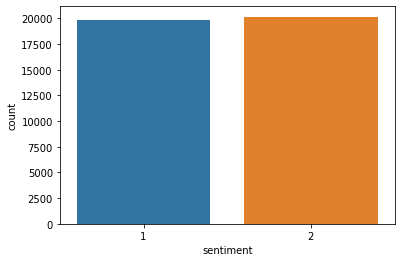

In [8]:
sns.countplot(x=df["sentiment"]); # plot the classes

Now we have a dataframe with a random sample of 40000 entries, 3 features and no empty values. We can sewe that we have an even distribution of positive and negative reviews.

In [9]:
# combine title and text
df['content'] = df['title']+' '+df['text'] 
df.content.head()

0    ZZZZZZZZZZZ Basically the movie is just people...
1    Rich, Engrossing This is a great work of histo...
2    My Mother... My Opinion?? It took me a while t...
3    A bit disappointed This was my first digital c...
4    review of Awakening Curry Buckle Darwin Bownes...
Name: content, dtype: object

## Text Processing in NLP projects:
* Convert all text to lowercase
* Remove punctuation marks
* Remove numbers
* Remove line break and enter \r \n
* Tokenize the text
* Stop words (remove unnecessary words)
* Remmove suffixes with Lemma and Stemma and find roots
* Using NER
* Convert texts to numbers with Vectorize

In [10]:
# function to process text, including Tokenizing, Lemmatizing and Stemmatizinh, Stop Words removals and NER
def preprocess_text(df, text_column, processed_column='text_processed', tokens_column='text_tokens', lemma_column='text_lemmatize', entities_column='text_entities'):
    # Convert text to lowercase and remove punctuation, numbers, and line breaks
    df[processed_column] = df[text_column].str.lower().apply(lambda x: re.sub(r'[^\w\s]|\d|\r|\n', '', x))
    
    # Tokenize the text of processed text
    df[tokens_column] = df[processed_column].apply(lambda x: nltk.word_tokenize(x))
    
    # Remove stop words from tokenized text
    stop_words = set(stopwords.words('english'))
    df[tokens_column] = df[tokens_column].apply(lambda x: [word for word in x if word not in stop_words])
    
    # Remmove suffixes with Lemma and Stemma and find roots
    df[lemma_column] = df[tokens_column].apply(lambda x: [stemmer.stem(lemmatizer.lemmatize(word)) for word in x])
    
    # NER - Extract named entities
    df[entities_column] = df[tokens_column].apply(lambda x: ne_chunk(pos_tag(x)))
    
    return df

In [11]:
df = preprocess_text(df, 'content')

In [12]:
# Let's have a look at our processed Data Frame
df.head()

,sentiment,title,text,content,text_processed,text_tokens,text_lemmatize,text_entities
0,1,ZZZZZZZZZZZ,Basically the movie is just people running aro...,ZZZZZZZZZZZ Basically the movie is just people...,zzzzzzzzzzz basically the movie is just people...,"[zzzzzzzzzzz, basically, movie, people, runnin...","[zzzzzzzzzzz, basic, movi, peopl, run, around,...","[(zzzzzzzzzzz, NN), (basically, RB), (movie, N..."
1,2,"Rich, Engrossing",This is a great work of history. It covers the...,"Rich, Engrossing This is a great work of histo...",rich engrossing this is a great work of histor...,"[rich, engrossing, great, work, history, cover...","[rich, engross, great, work, histori, cover, b...","[(rich, JJ), (engrossing, VBG), (great, JJ), (..."
2,2,My Mother... My Opinion??,It took me a while to get into this book... th...,My Mother... My Opinion?? It took me a while t...,my mother my opinion it took me a while to get...,"[mother, opinion, took, get, book, several, oc...","[mother, opinion, took, get, book, sever, occa...","[(mother, NN), (opinion, NN), (took, VBD), (ge..."
3,1,A bit disappointed,This was my first digital camera. At first I w...,A bit disappointed This was my first digital c...,a bit disappointed this was my first digital c...,"[bit, disappointed, first, digital, camera, fi...","[bit, disappoint, first, digit, camera, first,...","[(bit, NN), (disappointed, JJ), (first, JJ), (..."
4,2,review of Awakening Curry Buckle,Darwin Bownes is a 10th grader who moves to Kl...,review of Awakening Curry Buckle Darwin Bownes...,review of awakening curry buckle darwin bownes...,"[review, awakening, curry, buckle, darwin, bow...","[review, awaken, curri, buckl, darwin, bown, t...","[(review, NN), (awakening, VBG), (curry, JJ), ..."


Let's have a deeper look what our columns look like

In [13]:
df.text_processed[2] # show processed text number 3

'my mother my opinion it took me a while to get into this book there were several occasions where i tempted to give up on itim glad i stuck with it thoughthose of you with a difficult motherdaughter relationship will probably benefit from reading this book i know i did even though the author isnt a mother which does bother me a little i feel that her theories make sensethe version i have of this book is quite old and was published in i picked it up in a used bookstore im not sure what type of editing has been done on newer versions but im sure the main message will be the samemy mother my self would benefit women who would like a deeper understanding of their relationship with their own mother and also their daughters men might like to read this to understand the complex dynamics of these relationships'

We can see that the text is all in lower case, without punctuation marks, numbers or line breaks.

In [14]:
df.text_tokens[2] # show tokenized text number 3

['mother',
 'opinion',
 'took',
 'get',
 'book',
 'several',
 'occasions',
 'tempted',
 'give',
 'itim',
 'glad',
 'stuck',
 'thoughthose',
 'difficult',
 'motherdaughter',
 'relationship',
 'probably',
 'benefit',
 'reading',
 'book',
 'know',
 'even',
 'though',
 'author',
 'isnt',
 'mother',
 'bother',
 'little',
 'feel',
 'theories',
 'make',
 'sensethe',
 'version',
 'book',
 'quite',
 'old',
 'published',
 'picked',
 'used',
 'bookstore',
 'im',
 'sure',
 'type',
 'editing',
 'done',
 'newer',
 'versions',
 'im',
 'sure',
 'main',
 'message',
 'samemy',
 'mother',
 'self',
 'would',
 'benefit',
 'women',
 'would',
 'like',
 'deeper',
 'understanding',
 'relationship',
 'mother',
 'also',
 'daughters',
 'men',
 'might',
 'like',
 'read',
 'understand',
 'complex',
 'dynamics',
 'relationships']

We can see that we successfully tokenized our text, and also removed the stopwords.

In [15]:
df.text_lemmatize[2] # show lemmatized text number 3

['mother',
 'opinion',
 'took',
 'get',
 'book',
 'sever',
 'occas',
 'tempt',
 'give',
 'itim',
 'glad',
 'stuck',
 'thoughthos',
 'difficult',
 'motherdaught',
 'relationship',
 'probabl',
 'benefit',
 'read',
 'book',
 'know',
 'even',
 'though',
 'author',
 'isnt',
 'mother',
 'bother',
 'littl',
 'feel',
 'theori',
 'make',
 'senseth',
 'version',
 'book',
 'quit',
 'old',
 'publish',
 'pick',
 'use',
 'bookstor',
 'im',
 'sure',
 'type',
 'edit',
 'done',
 'newer',
 'version',
 'im',
 'sure',
 'main',
 'messag',
 'samemi',
 'mother',
 'self',
 'would',
 'benefit',
 'woman',
 'would',
 'like',
 'deeper',
 'understand',
 'relationship',
 'mother',
 'also',
 'daughter',
 'men',
 'might',
 'like',
 'read',
 'understand',
 'complex',
 'dynam',
 'relationship']

**Named Entity Recognition (NER)** is a technique used in natural language processing (NLP) to identify and classify named entities in text data. Named entities are specific words or phrases that represent real-world objects, such as people, organizations, locations, and dates.

In [16]:
df.text_entities # show entities of text number 3

0        [(zzzzzzzzzzz, NN), (basically, RB), (movie, N...
1        [(rich, JJ), (engrossing, VBG), (great, JJ), (...
2        [(mother, NN), (opinion, NN), (took, VBD), (ge...
3        [(bit, NN), (disappointed, JJ), (first, JJ), (...
4        [(review, NN), (awakening, VBG), (curry, JJ), ...
                               ...                        
39995    [(toxic, NN), (smell, NN), (smell, NN), (horri...
39996    [(useless, JJ), (collectors, NNS), (book, NN),...
39997    [(clambakes, NNS), (life, NN), (every, DT), (y...
39998    [(perfect, JJ), (shade, NN), (red, VBD), (cani...
39999    [(praise, NN), (thanks, NNS), (hollywoodites, ...
Name: text_entities, Length: 40000, dtype: object

Here we can see the results of NER, let's look closer in a nice diagram

**part-of-speech (POS)** tagging is a process of marking each word in a text with a POS tag to indicate its grammatical role in the sentence.  They are typically represented as a sequence of symbols that follow each word in the text, with each symbol representing a specific grammatical role. <br>
For example: NN: Noun, singular or mass, JJ: Adjective, VB: Verb..

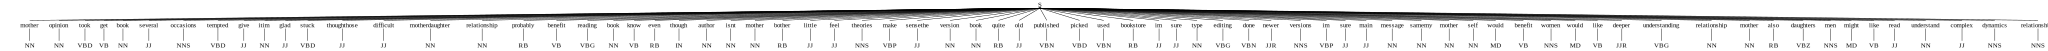

In [17]:
df.text_entities[2] # show entities of text number 3 visualized

We can see that our function did a great job in Text Processing. It was designed with the help of ChatGPT.

# Topic Modelling
In topic modelling, the goal is to identify the main topics or themes discussed in the text data and represent each document as a mixture of these topics. This is done by representing each document as a vector of weights, where each weight represents the relevance of a specific topic to the document.

In [18]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel

def topic_modeling(documents, dictionary, num_topics=10, num_words=10):
    # Create a corpus from the documents
    corpus = [dictionary.doc2bow(doc) for doc in documents]
    
    # Train the LDA model on the corpus
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
    
    # Print the top words for each topic
    for i, topic in lda.show_topics(num_words=num_words, formatted=False):
        print(f'Topic {i}: {[word for word, _ in topic]}')
    
    return lda

# Extract the list of documents from the DataFrame
documents = df['text_tokens'].tolist()

# Create a dictionary of the documents
dictionary = Dictionary(documents)

# Apply the topic modeling function to the documents
lda = topic_modeling(documents, dictionary=dictionary)

# Assign the topic assignments to a new column in the DataFrame
df['topics'] = [lda[dictionary.doc2bow(doc)] for doc in documents]

Topic 0: ['movie', 'dvd', 'film', 'watch', 'movies', 'video', 'great', 'watching', 'seen', 'see']
Topic 1: ['one', 'product', 'great', 'would', 'use', 'good', 'get', 'bought', 'time', 'buy']
Topic 2: ['game', 'like', 'fun', 'dont', 'good', 'one', 'much', 'play', 'would', 'games']
Topic 3: ['great', 'love', 'u', 'like', 'music', 'really', 'good', 'dance', 'na', 'best']
Topic 4: ['coffee', 'knife', 'workout', 'hose', 'cup', 'kitchen', 'grill', 'steel', 'en', 'vs']
Topic 5: ['book', 'read', 'great', 'good', 'one', 'books', 'information', 'many', 'well', 'reading']
Topic 6: ['book', 'read', 'one', 'story', 'like', 'good', 'would', 'really', 'time', 'characters']
Topic 7: ['cd', 'album', 'like', 'music', 'one', 'good', 'songs', 'great', 'best', 'song']
Topic 8: ['pack', 'clock', 'smells', 'sticks', 'manages', 'spare', 'blah', 'flaw', 'apple', 'golf']
Topic 9: ['people', 'book', 'us', 'life', 'world', 'man', 'women', 'young', 'love', 'one']


In [19]:
df.topics[3]

[(1, 0.6691907),
 (2, 0.07564219),
 (3, 0.0199464),
 (5, 0.083123475),
 (7, 0.14567077)]

This indicates that the text is assigned to topic 1 with a probability of 67%%, topic 7 with 15% and so on. This means that the document is more likely to belong to topic 1 according to the topic modeling algorithm.

## Visualize Topics
Here is an example of how you can visualize a single topic with a Wordcloud. Change the Id in the last column to make a Wordcloud of other topics.

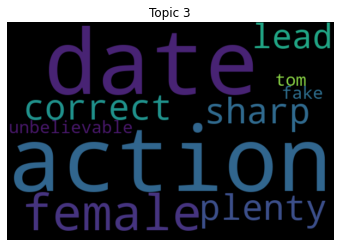

In [20]:
from wordcloud import WordCloud

def visualize_topic(lda, dictionary, topic_id):
    # Create a list of the top words for the topic
    top_words = [word for word, _ in lda.show_topic(topic_id, topn=10)]
    
    # Create a word cloud for the topic
    wordcloud = WordCloud(width=600, height=400).generate(' '.join(top_words))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Topic {topic_id}')
    plt.show()

# Extract the list of documents from the DataFrame
documents = df['text_tokens'].tolist()

# Create a dictionary of the documents
dictionary = Dictionary(documents)

# Train the LDA model on the corpus
lda = LdaModel([dictionary.doc2bow(doc) for doc in documents], id2word=dictionary)

# Visualize the topic with ID 3
visualize_topic(lda, dictionary, 3)

# Modelling - Text Classification
After assignin our X (features) and y (target), we use a Vectorizer to convert our text documents into a matrix, then we split our data to train and test sets and with various Classifiers we try to train our Model.<br>
The **CountVectorizer** is a tool from the scikit-learn library that can be used to convert a collection of text documents into a matrix of token counts. 

In [21]:
# replacing 1's to 0 and 2's to 1
df.sentiment.replace({1:0,2:1},inplace=True)
df.sentiment.unique()

array([0, 1])

In [22]:
# assign x and y - features are texts and target is label
x,y =df["text_processed"], df["sentiment"]
# Vectorize text data, removing stop words
vect=CountVectorizer(stop_words="english")
x=vect.fit_transform(x)
# split to train and test data
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=.15)

In [23]:
#importing Classification libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# create an instance of each classification algorithm
mb=MultinomialNB()
D=DecisionTreeClassifier()
KN=KNeighborsClassifier() 
R=RandomForestClassifier()
XGB=XGBClassifier()

classifiers = [mb, D, KN, R, XGB]

# list of classifier names
classifier_names = ['MultinomialNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'XGBClassifier']

# create an empty dataframe
result = pd.DataFrame(columns=['classifier', 'accuracy'])

# loop through classifiers and get predictions
for i, clf in enumerate(classifiers):
    pred = clf.fit(x_train, y_train).predict(x_test)
    score = accuracy_score(pred, y_test)
    result.loc[i] = [classifier_names[i], score]

In [24]:
# sort the dataframe by the accuracy column in descending order
result.sort_values(by='accuracy', ascending=False, inplace=True)
result # show results

,classifier,accuracy
3,RandomForestClassifier,0.854333
4,XGBClassifier,0.850667
0,MultinomialNB,0.836667
1,DecisionTreeClassifier,0.757500
2,KNeighborsClassifier,0.682333


We can see that the best result shows the **RandomForestClassifier with an Accuracy of 85,43%,** followed by the XGBClassifier with similar accuracy.

# Wordclouds
**Wordclouds (WC)** allow us the visual representations of the frequency and relative importance of words in a given body of text.

In [25]:
# Function to create a Wordcloud
def wc(data,bgcolor):
    plt.figure(figsize=(20,20))
    mask=np.array(Image.open("/kaggle/input/pics12/amazon.png"))
    wc=WordCloud(background_color=bgcolor,stopwords=STOPWORDS,mask=mask) 
    wc.generate(' '.join(data)) 
    plt.imshow(wc) 
    plt.axis("off")

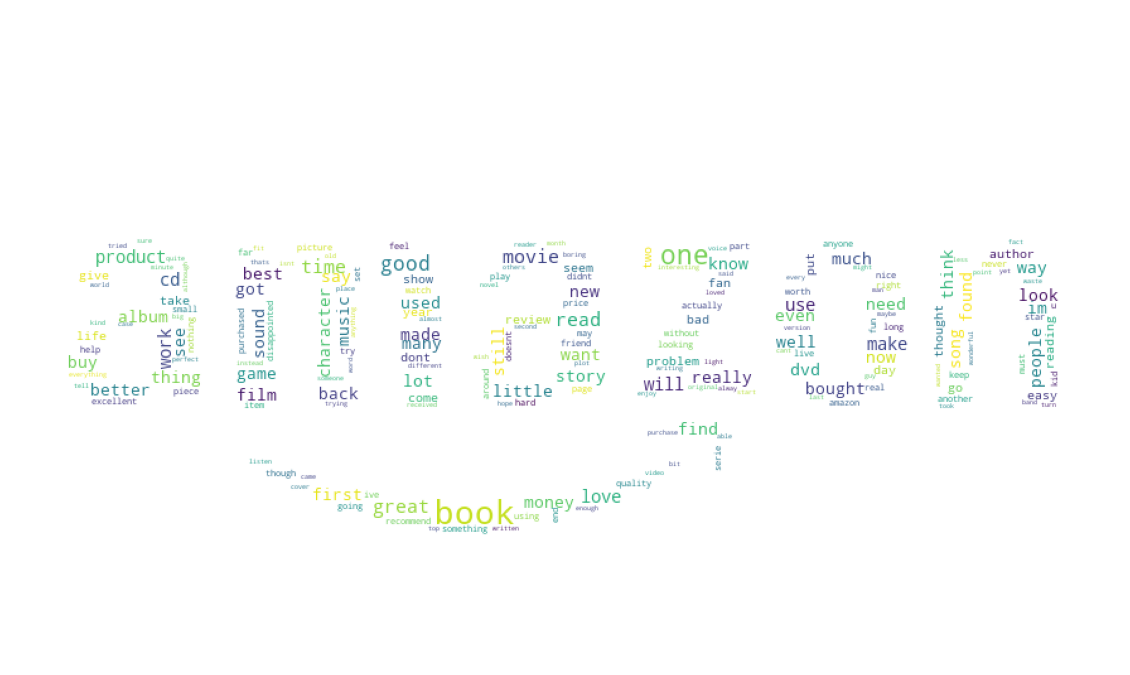

In [31]:
wc(df.text_processed,'white') # WC for processed text

# Sentiment Analysis

## Modelling
After assignin our X (features) and y (target), we use a Vectorizer to convert our text documents into a matrix, then we split our data to train and test sets and with various Classifiers we try to train our Model.

In [48]:
# assign x and y
x, y=df.text_processed, df.sentiment
# Vectorize X
vect=CountVectorizer(stop_words="english")
x=vect.fit_transform(x) 
# split into train and test sets
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=.15)

In [49]:
#importing Classification libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# create an instance of each classification algorithm
mb=MultinomialNB()
D=DecisionTreeClassifier()
KN=KNeighborsClassifier() 
R=RandomForestClassifier()
XGB=XGBClassifier()

classifiers = [mb, D, KN, R, XGB]

# list of classifier names
classifier_names = ['MultinomialNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'XGBClassifier']

# create an empty dataframe
res_sent = pd.DataFrame(columns=['classifier', 'accuracy'])

# loop through classifiers and get predictions
for i, clf in enumerate(classifiers):
    pred = clf.fit(x_train, y_train).predict(x_test)
    score = accuracy_score(pred, y_test)
    res_sent.loc[i] = [classifier_names[i], score]

In [50]:
# sort the dataframe by the accuracy column in descending order
res_sent.sort_values(by='accuracy', ascending=False, inplace=True)
res_sent # show results

,classifier,accuracy
3,RandomForestClassifier,0.862000
4,XGBClassifier,0.850667
0,MultinomialNB,0.836667
1,DecisionTreeClassifier,0.758833
2,KNeighborsClassifier,0.682333


Best result is showing the **RandomForestClassifier with an Accuracy of 86,2%**.

## Sentiment Analysis - Using TextBlob
Sentiment analysis with TextBlob: TextBlob can perform sentiment analysis on a text, which involves determining the overall sentiment expressed in the text (e.g., positive, negative, neutral).

In [36]:
# import TextBlob
from textblob import TextBlob

In [32]:
# function for sentiment analysis
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

In [33]:
# define new dataframe
df_sent=df[["text_processed"]] 
df_sent.head()

,text_processed
0,zzzzzzzzzzz basically the movie is just people...
1,rich engrossing this is a great work of histor...
2,my mother my opinion it took me a while to get...
3,a bit disappointed this was my first digital c...
4,review of awakening curry buckle darwin bownes...


In [37]:
# call sentiment function on our text and create new column with values
df_sent["polarity"]=df_sent["text_processed"].apply(detect_polarity)
df_sent.head()

,text_processed,polarity
0,zzzzzzzzzzz basically the movie is just people...,-0.277564
1,rich engrossing this is a great work of histor...,0.326250
2,my mother my opinion it took me a while to get...,0.062917
3,a bit disappointed this was my first digital c...,0.158333
4,review of awakening curry buckle darwin bownes...,0.082407


### Epsilon Neighborhood
In the context of sentiment analysis, epsilon neighborhoods can be used to identify reviews that express similar sentiments. For example, we might define an epsilon neighborhood around a review that is very positive, and then identify all other reviews that fall within that neighborhood as also being very positive.

In [39]:
# 1 positive
# 2 negative
# 0 neutral
def detect_sentiment(sent):
    if sent<-0.02: #0.02:limit
        return 2
    elif sent>0.02:
        return 1
    else:
        return 0

In [40]:
# apply new sentiment function 
df_sent["sentiment"]=df_sent["polarity"].apply(detect_sentiment)
df_sent.head()

,text_processed,polarity,sentiment
0,zzzzzzzzzzz basically the movie is just people...,-0.277564,2
1,rich engrossing this is a great work of histor...,0.326250,1
2,my mother my opinion it took me a while to get...,0.062917,1
3,a bit disappointed this was my first digital c...,0.158333,1
4,review of awakening curry buckle darwin bownes...,0.082407,1


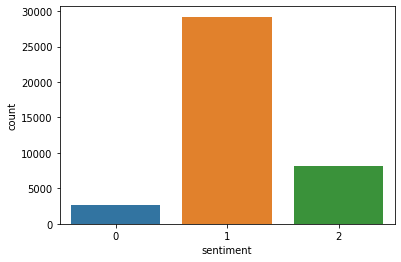

In [41]:
sns.countplot(df_sent.sentiment); # plot the sentiment analysis

In [43]:
df_sent.sentiment.value_counts()

1    29200
2     8116
0     2684
Name: sentiment, dtype: int64

We have 2900 positive, 8116 negative and 2684 neutral reviews.

## Modeling - Sentiment Analysis with TextBlob

In [44]:
# assign x and y
x, y=df_sent.text_processed, df_sent.sentiment
# Vectorize X
vect=CountVectorizer(stop_words="english")
x=vect.fit_transform(x) 
# split into train and test sets
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=.15)

In [45]:
#importing Classification libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# create an instance of each classification algorithm
mb=MultinomialNB()
D=DecisionTreeClassifier()
KN=KNeighborsClassifier() 
R=RandomForestClassifier()
XGB=XGBClassifier()

classifiers = [mb, D, KN, R, XGB]

# list of classifier names
classifier_names = ['MultinomialNB', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'RandomForestClassifier', 'XGBClassifier']

# create an empty dataframe
df2 = pd.DataFrame(columns=['classifier', 'accuracy'])

# loop through classifiers and get predictions
for i, clf in enumerate(classifiers):
    pred = clf.fit(x_train, y_train).predict(x_test)
    score = accuracy_score(pred, y_test)
    df2.loc[i] = [classifier_names[i], score]

In [46]:
# sort the dataframe by the accuracy column in descending order
df2.sort_values(by='accuracy', ascending=False, inplace=True)
df2 # show results

,classifier,accuracy
4,XGBClassifier,0.847167
3,RandomForestClassifier,0.813000
0,MultinomialNB,0.797000
1,DecisionTreeClassifier,0.773333
2,KNeighborsClassifier,0.667333


Using TextBlob for the Sentiment Analysis, the **XGBClassifier** scored the highest with an Accurcy of **84,72%.**